In [ ]:
import os
import logging, os

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [1]:
import tensorflow as tf
from tensorflow import keras
from musicnet.utils import create_tf_record_ds
from musicnet.model.Transformer import loss_fn, F1FromSeqLogits
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

2024-07-11 13:13:12.419041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 13:13:12.540811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 13:13:12.572469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 13:13:12.797472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 13:13:14.232522: W tensorflow/compiler/tf2

In [2]:
model = keras.models.load_model(
    "../musicnet/model.keras",
    {
        "loss_fn": loss_fn,
        "F1FromSeqLogits": F1FromSeqLogits
    }
)

/home/leszek/projects/musicnet/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/leszek/projects/musicnet/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1720696398.784529  509643 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/test

In [3]:
model_config = model.get_config()
print(model_config)

{'n_mels': 100, 'd_model': 128, 'target_classes': 913, 'num_layers': 4, 'num_heads': 8, 'dff': 512, 'seq_len': 1000, 'mha_dropout': 0.0, 'input_dropout': 0.0}


In [6]:
train_ds = create_tf_record_ds("train", model_config["n_mels"], model_config["target_classes"], 8)
val_ds = create_tf_record_ds("val", model_config["n_mels"], model_config["target_classes"], 8)

In [7]:
# Encoder only architecture
train_ds = train_ds.map(lambda *batch: (batch[0][0], batch[1][:, :-1, :]))
val_ds = val_ds.map(lambda *batch: (batch[0][0], batch[1][:, :-1, :]))

In [8]:
model.evaluate(val_ds)

I0000 00:00:1720559149.381828  245049 service.cc:146] XLA service 0x7f9228045460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720559149.381868  245049 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6


      5/Unknown 15s 35ms/step - f1_score: 0.0830 - loss: 0.8051

I0000 00:00:1720559163.404609  245049 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - f1_score: 0.0732 - loss: 0.7877


/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.7748851776123047, 0.06984792649745941]

: 

In [20]:
def plot_y_vs_y_pred(y, y_pred):
    y = y.T.reshape((*y.T.shape, 1))
    y_pred = y_pred.T.reshape((*y_pred.T.shape, 1))
    pixels = np.where(
        y_pred == True,
        # True positive: green, False positive: red
        np.where(y == True, np.array([0, 255, 0]), np.array([255, 0, 0])),
        # False negative: blue, True negative: black
        np.where(y == True, np.array([0, 0, 255]), np.array([0, 0, 0]))
    )
    img = Image.fromarray(pixels.astype(np.uint8))
    display(img)
    # plt.figure(figsize=(20, 20))
    # plt.title("y_true")
    # plt.imshow(y.T * 1.0, cmap="gray", aspect="equal", interpolation="none")
    # plt.axis("off")
    # plt.tight_layout(pad=0)
    # plt.show()

    # plt.title("y_pred")
    # plt.imshow(y_pred.T * 1.0, cmap="gray", aspect="equal", interpolation="none")
    # plt.colorbar()
    # plt.show()

In [21]:
for x, y in val_ds:
    x = x[:1]
    y = y[:1]
    break

In [22]:
print(x.shape, y.shape)

(1, 998, 128) (1, 998, 913)


In [217]:
# @tf.function
# def run_inference(context, max_len=999, head_start=0):
#     y_pred = tf.TensorArray(dtype=tf.bool, size=0, dynamic_size=True)
#     for i in tf.range(head_start):
#         y_pred = y_pred.write(i, y[-1, i, :])
#     for i in tf.range(head_start, max_len):
#         next_pred = model([context, [y_pred.stack()]], training=False)[-1, -1, :]
#         next_pred = tf.sigmoid(next_pred)
#         y_pred = y_pred.write(i, next_pred > 0.5)
#     return y_pred.stack()

In [251]:
# y_pred_infer = run_inference(context, y.shape[1], head_start=100)
# y_pred_context = model([context, x])[0]
# y_pred_context = tf.sigmoid(y_pred_context).numpy() > 0.5

In [32]:
y_pred = model(x)[0]
y_pred = tf.sigmoid(y_pred) > 0.99

In [33]:
print(y_pred.shape)

(998, 913)


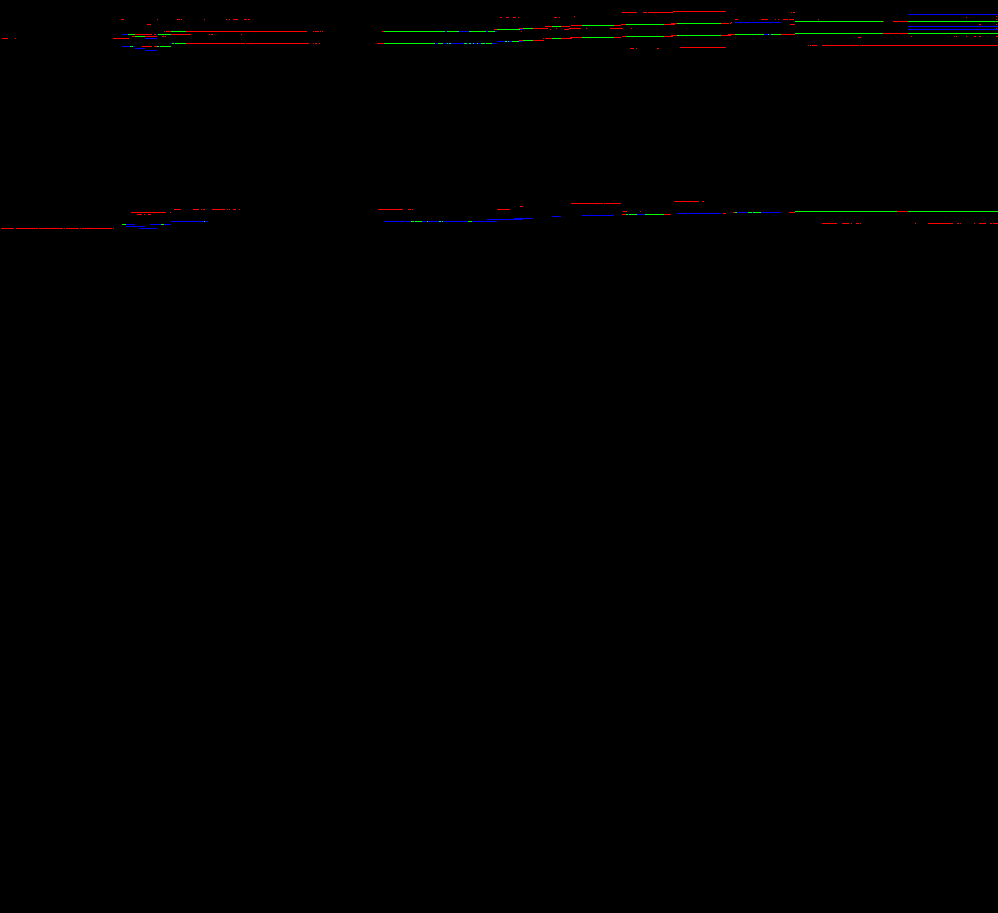

: 

In [34]:
plot_y_vs_y_pred(y[0].numpy(), y_pred.numpy())

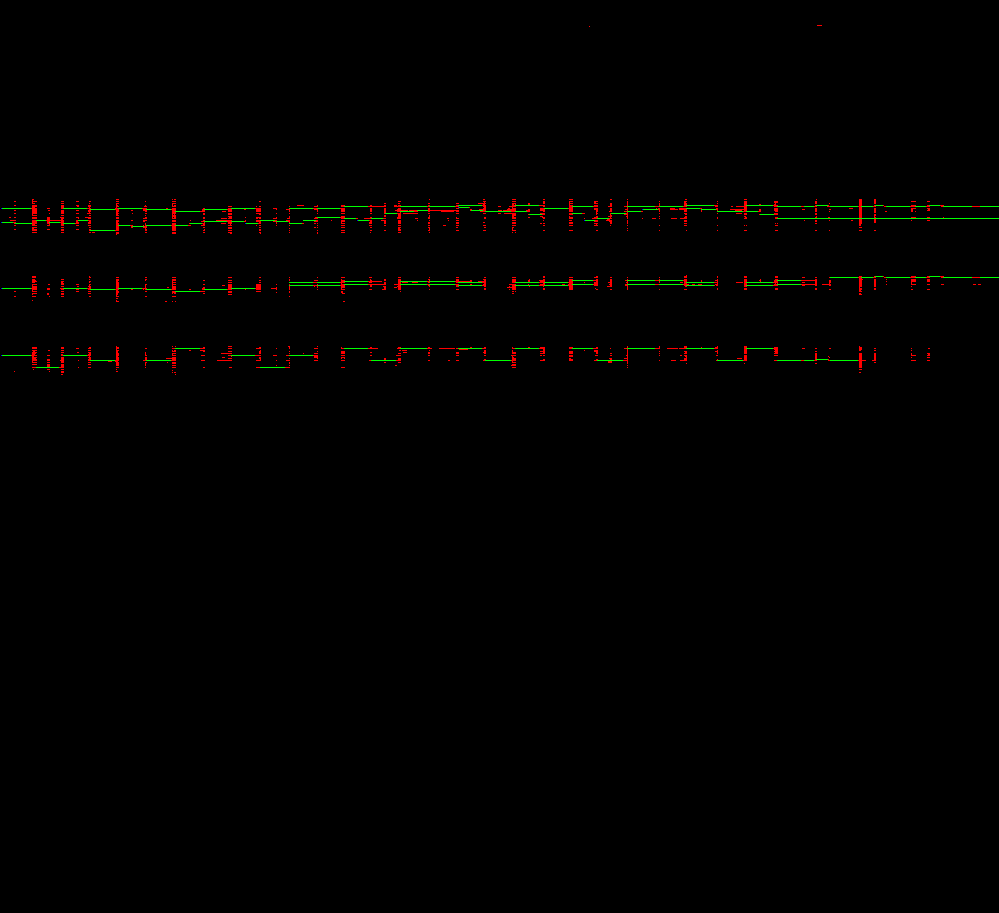

In [256]:
plot_y_vs_y_pred(y[0].numpy(), y_pred_context)